In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import warnings
from bokeh.plotting import figure, show, output_notebook
from bokeh.io import output_notebook
from bokeh.models import HoverTool, Range1d, ColumnDataSource
import bokeh

warnings.filterwarnings('ignore')
output_notebook()
%matplotlib inline
plt.style.use('default')


Loading BokehJS ...

In [59]:
stn_ids = pd.read_fwf(
    'http://noaa-ghcn-pds.s3.amazonaws.com/ghcnd-stations.txt',
    header=None, infer_nrows=1000
)
stn_ids.columns = ['ID', 'LAT', 'LON', 'ELEV', 'UKN', 'NAME', 'GSN', 'WBAN']

periods = pd.read_fwf(
    'http://noaa-ghcn-pds.s3.amazonaws.com/ghcnd-inventory.txt',
    header=None, infer_nrows=1000
)
periods.columns = ['ID', 'LAT', 'LON', 'ELEM', 'TiMIN', 'TiMAX']

merged_stns = pd.merge(
    stn_ids, periods, how='left', left_on='ID', right_on='ID'
)
merged_stns = merged_stns[
    (merged_stns['ELEM'] == 'TMAX') & (merged_stns['TiMAX'] == 2025)
]

champaign_station_id = 'USC00118740'
berlin_station_id = 'GME00127438'


In [60]:
def analyze_weather_station(station_id):
    """
    Download GHCN Daily Data from AWS and calculate temperature statistics.
    
    Parameters:
    -----------
    station_id : str
        GHCN station ID
    
    Returns:
    --------
    pandas.DataFrame
        DataFrame with temperature statistics for each day of year
    """
    print(f"Downloading data for station: {station_id}")
    
    try:
        df = pd.read_csv(
            f"s3://noaa-ghcn-pds/csv/by_station/{station_id}.csv",
            storage_options={"anon": True},
            dtype={'Q_FLAG': 'object', 'M_FLAG': 'object'},
            parse_dates=['DATE']
        ).set_index('DATE')
        
        df_tmax = df[df['ELEMENT'] == 'TMAX'].copy()
        df_tmin = df[df['ELEMENT'] == 'TMIN'].copy()
        
        df_tmax['TEMP_C'] = df_tmax['DATA_VALUE'] / 10.0
        df_tmin['TEMP_C'] = df_tmin['DATA_VALUE'] / 10.0
        
        df_tmax['day_of_year'] = df_tmax.index.dayofyear
        df_tmin['day_of_year'] = df_tmin.index.dayofyear
        
        results = []
        
        for day in range(1, 367):
            tmax_day = df_tmax[df_tmax['day_of_year'] == day]['TEMP_C']
            tmin_day = df_tmin[df_tmin['day_of_year'] == day]['TEMP_C']
            
            if len(tmax_day) > 0 and len(tmin_day) > 0:
                record_max = tmax_day.max()
                record_min = tmin_day.min()
                
                normal_period = (
                    (df_tmax.index >= '1991-01-01') & 
                    (df_tmax.index <= '2020-12-31')
                )
                tmax_normal = df_tmax[
                    (df_tmax['day_of_year'] == day) & normal_period
                ]['TEMP_C']
                tmin_normal = df_tmin[
                    (df_tmin['day_of_year'] == day) & normal_period
                ]['TEMP_C']
                
                avg_max = tmax_normal.mean() if len(tmax_normal) > 0 else np.nan
                avg_min = tmin_normal.mean() if len(tmin_normal) > 0 else np.nan
                
                results.append({
                    'day_of_year': day,
                    'record_min_temp': record_min,
                    'average_min_temp': avg_min,
                    'average_max_temp': avg_max,
                    'record_max_temp': record_max
                })
        
        result_df = pd.DataFrame(results)
        result_df = result_df.set_index('day_of_year')
        
        print(f"Successfully processed {len(result_df)} days of data")
        print(f"Data range: {df.index.min().strftime('%Y-%m-%d')} to "
              f"{df.index.max().strftime('%Y-%m-%d')}")
        
        return result_df
        
    except Exception as e:
        print(f"Error processing station {station_id}: {str(e)}")
        return None


In [61]:
def get_year_data(station_id, year):
    """
    Get actual temperature data for a specific year and station.
    
    Parameters:
    -----------
    station_id : str
        GHCN station ID
    year : int
        Year to get data for
    
    Returns:
    --------
    pandas.DataFrame
        DataFrame with actual TMAX and TMIN for each day of the year
    """
    df = pd.read_csv(
        f"s3://noaa-ghcn-pds/csv/by_station/{station_id}.csv",
        storage_options={"anon": True},
        dtype={'Q_FLAG': 'object', 'M_FLAG': 'object'},
        parse_dates=['DATE']
    ).set_index('DATE')
    
    year_data = df[df.index.year == year].copy()
    
    tmax_year = year_data[year_data['ELEMENT'] == 'TMAX']['DATA_VALUE'] / 10.0
    tmin_year = year_data[year_data['ELEMENT'] == 'TMIN']['DATA_VALUE'] / 10.0
    
    year_df = pd.DataFrame({
        'TMAX': tmax_year,
        'TMIN': tmin_year
    })
    
    year_df['day_of_year'] = year_df.index.dayofyear
    
    return year_df


In [62]:
def create_temperature_plot(stats_df, year_df, station_name, year):
    """
    Create a comprehensive temperature plot using matplotlib.
    
    Parameters:
    -----------
    stats_df : pandas.DataFrame
        DataFrame with temperature statistics for each day of year
    year_df : pandas.DataFrame
        DataFrame with actual temperature data for the specific year
    station_name : str
        Name of the weather station for the plot title
    year : int
        Year of the actual data
    """
    fig, ax = plt.subplots(figsize=(15, 10))
    
    days = stats_df.index
    
    ax.fill_between(
        days, stats_df['record_min_temp'], stats_df['record_max_temp'],
        alpha=0.2, color='red', label='All-time Record Range'
    )
    
    ax.fill_between(
        days, stats_df['average_min_temp'], stats_df['average_max_temp'],
        alpha=0.4, color='blue', label='Normal Range (1991-2020)'
    )
    
    if year_df is not None and len(year_df) > 0:
        year_merged = year_df.set_index('day_of_year')
        
        ax.plot(
            year_merged.index, year_merged['TMAX'], 'o-',
            color='darkred', markersize=2, linewidth=1,
            label=f'Actual High {year}'
        )
        ax.plot(
            year_merged.index, year_merged['TMIN'], 'o-',
            color='darkblue', markersize=2, linewidth=1,
            label=f'Actual Low {year}'
        )
    
    ax.set_xlabel('Day of Year', fontsize=12)
    ax.set_ylabel('Temperature (°C)', fontsize=12)
    ax.set_title(
        f'Temperature Analysis: {station_name} - {year}',
        fontsize=14, fontweight='bold'
    )
    
    month_days = [1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335]
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                   'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    ax.set_xticks(month_days)
    ax.set_xticklabels(month_names)
    
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper right', fontsize=10)
    
    y_min = min(
        stats_df['record_min_temp'].min(),
        stats_df['average_min_temp'].min()
    ) - 5
    y_max = max(
        stats_df['record_max_temp'].max(),
        stats_df['average_max_temp'].max()
    ) + 5
    ax.set_ylim(y_min, y_max)
    
    stats_text = f"""Statistics for {year}:
    • Days with data: {len(year_df) if year_df is not None else 0}
    • Warmest day: {year_df['TMAX'].max():.1f}°C (Day {year_df.loc[year_df['TMAX'].idxmax(), 'day_of_year'] if year_df is not None and len(year_df) > 0 else 'N/A'})
    • Coldest day: {year_df['TMIN'].min():.1f}°C (Day {year_df.loc[year_df['TMIN'].idxmin(), 'day_of_year'] if year_df is not None and len(year_df) > 0 else 'N/A'})"""
    
    ax.text(
        0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=9,
        verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    )
    
    plt.tight_layout()
    return fig


In [63]:
def create_bokeh_temperature_plot(stats_df, year_df, station_name, year):
    """
    Create an interactive Bokeh plot showing temperature data.
    
    Parameters:
    -----------
    stats_df : pandas.DataFrame
        DataFrame with temperature statistics for each day of year
    year_df : pandas.DataFrame
        DataFrame with actual temperature data for the specific year
    station_name : str
        Name of the weather station for the plot title
    year : int
        Year of the actual data
    """
    days = stats_df.index.values
    
    source_stats = ColumnDataSource(data={
        'day_of_year': days,
        'record_min': stats_df['record_min_temp'].values,
        'record_max': stats_df['record_max_temp'].values,
        'avg_min': stats_df['average_min_temp'].values,
        'avg_max': stats_df['average_max_temp'].values
    })
    
    if year_df is not None and len(year_df) > 0:
        year_merged = year_df.set_index('day_of_year')
        source_year = ColumnDataSource(data={
            'day_of_year': year_merged.index.values,
            'actual_max': year_merged['TMAX'].values,
            'actual_min': year_merged['TMIN'].values
        })
    else:
        source_year = ColumnDataSource(data={
            'day_of_year': [],
            'actual_max': [],
            'actual_min': []
        })
    
    p = figure(
        title=f'Temperature Analysis: {station_name} - {year}',
        x_axis_label='Day of Year',
        y_axis_label='Temperature (°C)',
        width=800,
        height=500,
        tools='pan,wheel_zoom,box_zoom,reset,save,hover'
    )
    
    month_days = [1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335]
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                   'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    p.xaxis.ticker = month_days
    p.xaxis.major_label_overrides = dict(zip(month_days, month_names))
    
    p.varea(
        x='day_of_year', y1='record_min', y2='record_max',
        source=source_stats, alpha=0.2, color='red',
        legend_label='All-time Record Range'
    )
    
    p.varea(
        x='day_of_year', y1='avg_min', y2='avg_max',
        source=source_stats, alpha=0.4, color='blue',
        legend_label='Normal Range (1991-2020)'
    )
    
    if year_df is not None and len(year_df) > 0:
        p.line(
            x='day_of_year', y='actual_max', source=source_year,
            color='darkred', line_width=2,
            legend_label=f'Actual High {year}'
        )
        p.line(
            x='day_of_year', y='actual_min', source=source_year,
            color='darkblue', line_width=2,
            legend_label=f'Actual Low {year}'
        )
        
        p.circle(
            x='day_of_year', y='actual_max', source=source_year,
            color='darkred', size=3, alpha=0.6
        )
        p.circle(
            x='day_of_year', y='actual_min', source=source_year,
            color='darkblue', size=3, alpha=0.6
        )
    
    hover = p.select_one(HoverTool)
    hover.tooltips = [
        ('Day of Year', '@day_of_year'),
        ('Record Min', '@record_min{0.1f}°C'),
        ('Record Max', '@record_max{0.1f}°C'),
        ('Avg Min', '@avg_min{0.1f}°C'),
        ('Avg Max', '@avg_max{0.1f}°C'),
    ]
    
    if year_df is not None and len(year_df) > 0:
        hover.tooltips.extend([
            ('Actual Min', '@actual_min{0.1f}°C'),
            ('Actual Max', '@actual_max{0.1f}°C'),
        ])
    
    p.legend.location = 'top_right'
    p.legend.click_policy = 'hide'
    p.grid.grid_line_alpha = 0.3
    p.background_fill_color = 'white'
    
    y_min = min(
        stats_df['record_min_temp'].min(),
        stats_df['average_min_temp'].min()
    ) - 5
    y_max = max(
        stats_df['record_max_temp'].max(),
        stats_df['average_max_temp'].max()
    ) + 5
    p.y_range = Range1d(y_min, y_max)
    
    return p


In [64]:
champaign_stats = analyze_weather_station(champaign_station_id)
berlin_stats = analyze_weather_station(berlin_station_id)

champaign_2022 = get_year_data(champaign_station_id, 2022)
berlin_2022 = get_year_data(berlin_station_id, 2022)


Successfully processed 366 days of data
Data range: 1902-08-01 to 2025-10-06
Successfully processed 366 days of data
Data range: 1961-01-01 to 2025-03-31


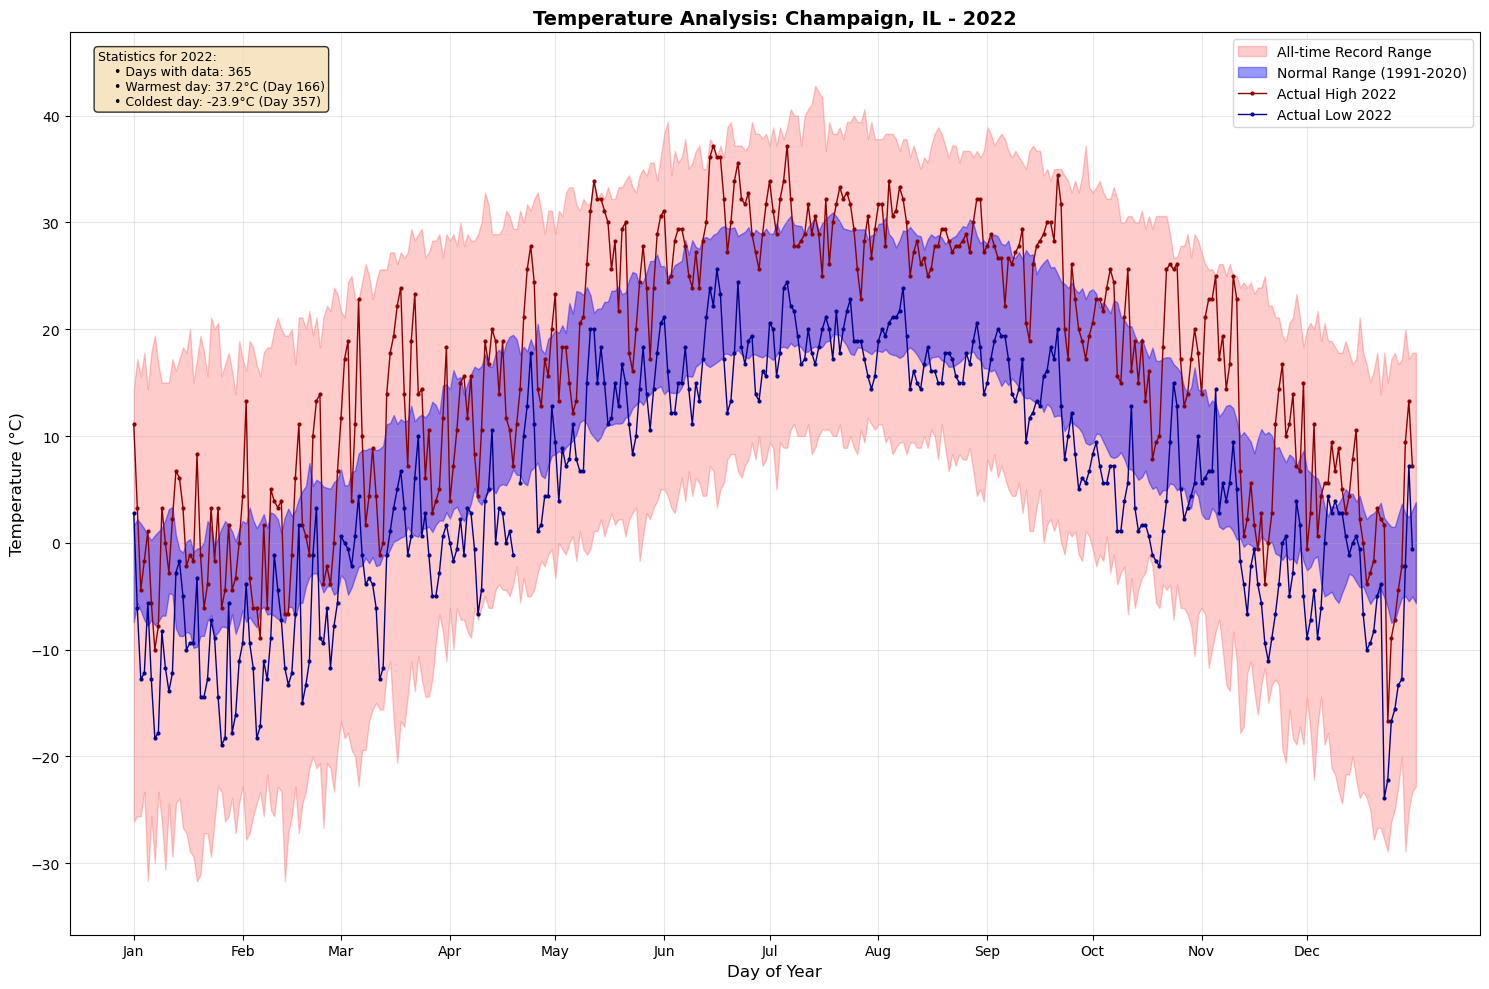

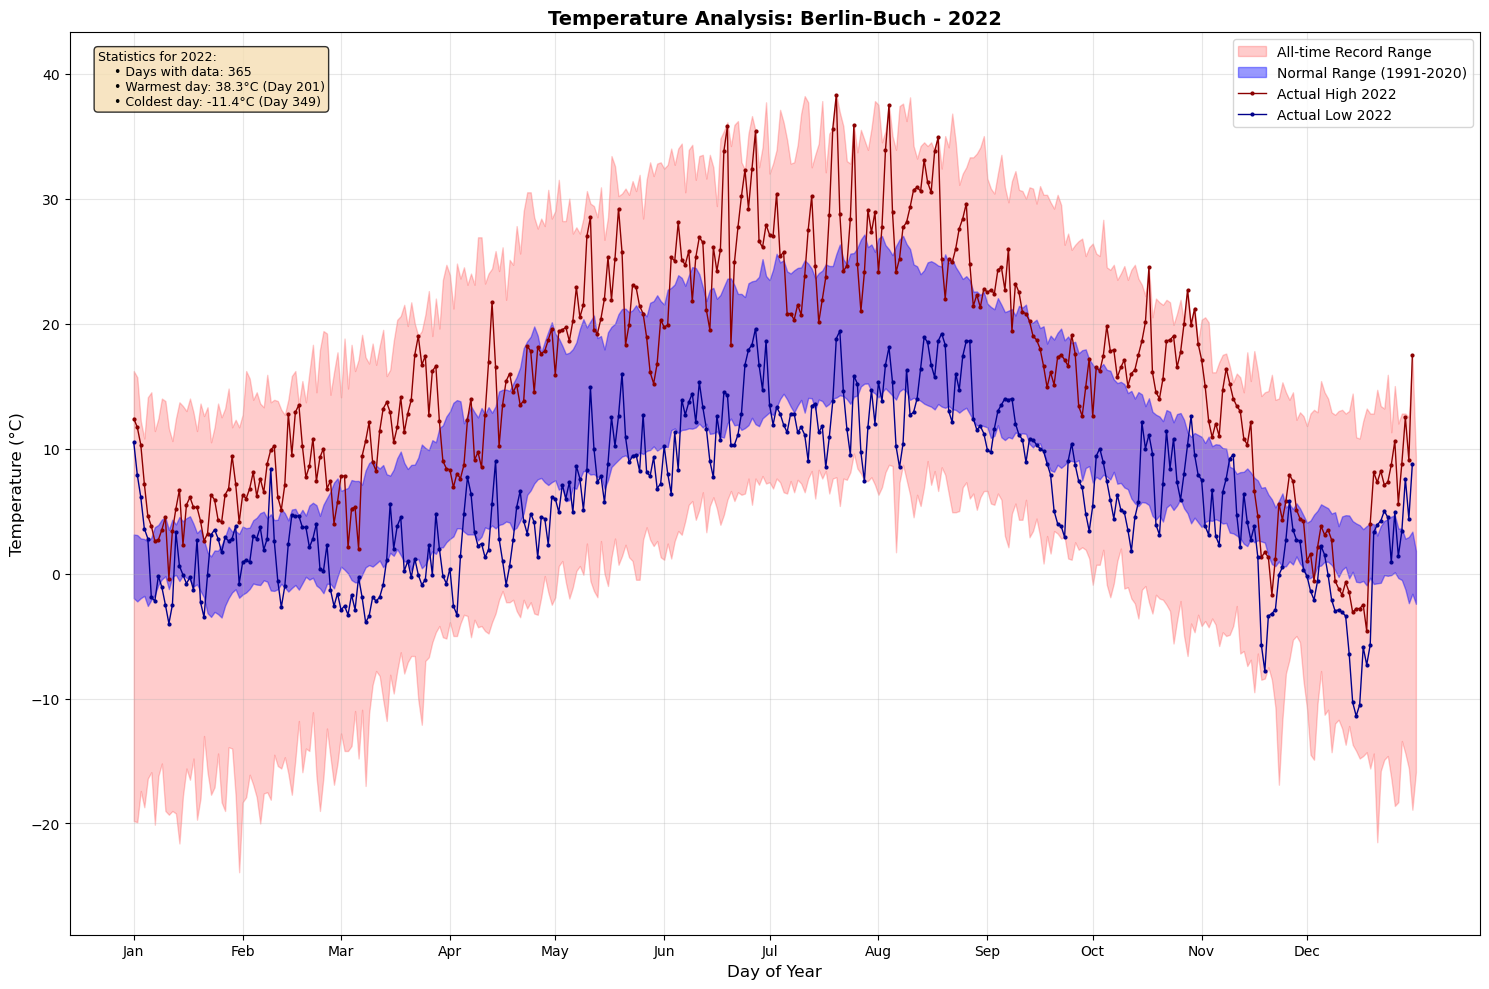

In [66]:
if champaign_stats is not None:
    fig = create_temperature_plot(
        champaign_stats, champaign_2022, 'Champaign, IL', 2022
    )
    plt.show()

if berlin_stats is not None:
    fig = create_temperature_plot(
        berlin_stats, berlin_2022, 'Berlin-Buch', 2022
    )
    plt.show()


In [68]:
if champaign_stats is not None:
    champaign_bokeh_plot = create_bokeh_temperature_plot(
        champaign_stats, champaign_2022, 'Champaign, IL', 2022
    )
    show(champaign_bokeh_plot)

if berlin_stats is not None:
    berlin_bokeh_plot = create_bokeh_temperature_plot(
        berlin_stats, berlin_2022, 'Berlin-Buch', 2022
    )
    show(berlin_bokeh_plot)
